# Spot the Mask Challenge

## Import Libraries

In [1]:
# !pip install ignite
# !pip install albumentations
# !pip install pretrainedmodels

In [2]:
import os, sys, gc
import numpy as np
import pandas as pd
import random
import ignite
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import *

from PIL import Image
import albumentations
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from random import shuffle 
%matplotlib inline

In [3]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(2020)

In [5]:
# torch.__version__, ignite.__version__
# Check if pytorch is imported and if GPU is enabled
print(torch.__version__)
print(torch.cuda.is_available())

1.3.1
True


In [6]:
path = './'
train_dir = path+'images'
test_dir = path+'images'
df = pd.read_csv(path+'train_labels.csv')
df_sample = pd.read_csv(path+'sample_sub_v2.csv')
df.head(1)

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0


## Create Folds

In [7]:
df.loc[:, 'kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
X = df.image.values
y = df.target.values

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

folds = StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(folds.split(X, y)):
#     print("TRAIN: ", trn_, "VAL: ", val_)
    df.loc[val_, "kfold"] = fold

print(df.kfold.value_counts())
df.to_csv("./input/train_folds.csv", index=False)

2    262
1    262
0    262
4    261
3    261
Name: kfold, dtype: int64


## Set Environment Variables

In [7]:
device = "cuda"
last_epoch = []
last_val_loss = []

## Load Train Data From DataFrame

In [8]:
class from_df(Dataset):
    def __init__(self, dir, df, folds, image_class, mode='train'):
        self.mode= mode
        
        if self.mode == 'train':
            df = df[df.kfold.isin(folds)].reset_index(drop=True)
            self.image_list = [x for x in df[image_class[0]]]
            self.target_list = [x for x in df[image_class[1]]]
            self.df = df
            self.no_of_classes = len(df[image_class[1]].value_counts())
            if len(folds) == 1:
                self.transform = albumentations.Compose([
                    albumentations.Resize(256, 256, always_apply=True),
                    albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
                ])
            else:
                self.transform = albumentations.Compose([
                    albumentations.Resize(256, 256, always_apply=True),
                    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=5, p=0.9),
                    albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
                ])
        else:
            self.image_list = [x for x in df[image_class]]
            self.df = df
            self.no_of_classes = 0
            self.transform = albumentations.Compose([
                albumentations.Resize(256, 256, always_apply=True),
                albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
            ])
            
        self.dir = dir
        self.image_class = image_class
            
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.image_list[idx]))
        img = img.convert("RGB")
        img = self.transform(image=np.array(img))['image']
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        if self.mode == 'train':
            return torch.tensor(img, dtype=torch.float), self.target_list[idx]
        else:
            return torch.tensor(img, dtype=torch.float), self.image_list[idx]

    def info(self):
        print("Number of Classes:", self.no_of_classes)

In [9]:
# train 4x with different folds
training_folds = (0, 1, 2, 3)
validation_folds = (4,)
bs = 16
bs_test = 16

training_folds_csv = "./input/train_folds.csv"
df_folds = pd.read_csv(training_folds_csv)

train_dataset = from_df(train_dir, df_folds, training_folds, ('image', 'target'))
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle=True)

valid_dataset = from_df(train_dir, df_folds, validation_folds, ('image', 'target'))
valid_loader = DataLoader(valid_dataset, batch_size = bs_test, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


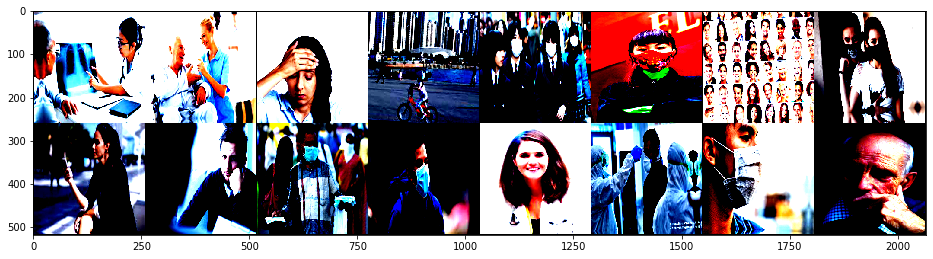

In [10]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

## Model Building

In [11]:
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

class ResNet50(nn.Module):
    def __init__(self, pretrained):
        super(ResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

class Se_ResNet50(nn.Module):
    def __init__(self, pretrained):
        super(Se_ResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["se_resnet50"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["se_resnet50"](pretrained=None)        
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

class Se_ResNext50_32x4d(nn.Module):
    def __init__(self, pretrained):
        super(Se_ResNext50_32x4d, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained=None)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

class Se_ResNext101_32x4d(nn.Module):
    def __init__(self, pretrained):
        super(Se_ResNext101_32x4d, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["se_resnext101_32x4d"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["se_resnext101_32x4d"](pretrained=None)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

class SeNet154(nn.Module):
    def __init__(self, pretrained):
        super(SeNet154, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["senet154"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["senet154"](pretrained=None)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return x

In [12]:
model_dispatcher = {
    "resnet34": ResNet34,
    "resnet50": ResNet50,
    "se_resnet50": Se_ResNet50,
    "se_resnext50_32x4d": Se_ResNext50_32x4d,
    "se_resnext101_32x4d": Se_ResNext101_32x4d,
    "senet154": SeNet154,
}

In [13]:
model = model_dispatcher['se_resnext50_32x4d'](pretrained=False)
model

Se_ResNext50_32x4d(
  (model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Training

In [14]:
base_model = "se_resnext50_32x4d"
model = model_dispatcher[base_model](pretrained=True)

model = model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [15]:
def train(dataset, data_loader, model):
    model.train()
    total = []
    for bi, (images, labels) in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        outputs = model(images)
        outputs = outputs.to("cpu").detach().numpy()
        return outputs
        
def evaluate(dataset, data_loader, model):
    model.eval()
    total = []
    for bi, (images, labels) in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        outputs = model(images)
        outputs = outputs.to("cpu").detach().numpy()
        return outputs

In [16]:
train_score = train(train_dataset, train_loader, model)
# val_score = evaluate(valid_dataset, valid_loader, model)

  0%|          | 0/65 [00:00<?, ?it/s]


In [17]:
train_score

array([[4.3071132e-02, 1.9055754e-01, 1.1494508e+00, ..., 1.0063132e+00,
        6.5900719e-01, 8.0557525e-01],
       [6.1998353e-04, 1.7488647e-01, 4.3868354e-01, ..., 3.3123457e-01,
        2.6635740e-02, 3.9607957e-02],
       [4.0624225e-01, 0.0000000e+00, 1.4429097e-02, ..., 2.3487978e-02,
        0.0000000e+00, 3.7809438e-01],
       ...,
       [1.3059987e-01, 4.3015582e-03, 1.8689756e-01, ..., 6.3738048e-01,
        1.7996086e-02, 1.0542989e-01],
       [5.5306703e-01, 2.2628669e-02, 1.1988913e-01, ..., 5.7946706e-01,
        1.8389474e+00, 1.5242426e-01],
       [1.7075035e-01, 2.2230625e-02, 3.0430835e-01, ..., 6.8227720e-01,
        1.2497132e-01, 3.2169238e-01]], dtype=float32)

In [0]:
model_state = torch.load("models/"+f"{base_model}_fold{validation_folds[0]}.bin", map_location=lambda storage, loc: storage)
model.load_state_dict(model_state, strict=False)

<All keys matched successfully>

In [0]:
print(last_val_loss)
print("Mean:", sum(last_val_loss)/len(last_val_loss))

[tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>)]
Mean: tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>)


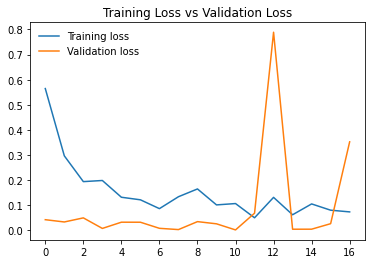

In [0]:
plt.plot(train_loss_list, label = 'Training loss')
plt.plot(valid_loss_list, label = 'Validation loss')
plt.legend(frameon = False)
plt.title('Training Loss vs Validation Loss')
plt.show()

## Train on Full Dataset

In [0]:
train_dataset = from_df(train_dir, df_folds, (0, 1, 2, 3, 4), ('image', 'target'))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers=4)

epochs = 50
# sum(last_epoch)//len(last_epoch)
save_dir = 'models/'

for epoch in range(epochs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    train_score = train(train_dataset, train_loader, model, optimizer)
    scheduler.step(train_score)

torch.save(model.state_dict(), "model.pt")


100%|██████████| 81/81 [01:11<00:00,  1.15it/s]
82it [01:12,  1.13it/s]

 59%|█████▉    | 48/81 [00:42<00:28,  1.15it/s]

## Load Best Model

In [0]:
def load_checkpoint(file='model.pt'):
    model_state = torch.load(file, map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state, strict=False)
    return model

model = load_checkpoint()
model = model.to(device)

## Load Test Data

In [0]:
testset = from_df(test_dir, df_sample, validation_folds, 'image', mode='test')
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

## Testing

In [0]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.sigmoid(output)[:, 1]
        fn_list += [n for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame(np.stack([fn_list, pred_list], axis=1), columns=df_sample.columns)
submission.to_csv('submission.csv', index=False)

In [0]:
submission.head()

In [0]:
len(df_sample['image']==submission['image'])

## Validation

In [0]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.sigmoid(output)[:, 1]
pred = [p.item() for p in pred]
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(pred[num])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))